# Self-supervised

This example shows how to train a neural operator on sine functions
in a self-supervised manner.

## Setup

In [1]:
import torch
import matplotlib.pyplot as plt
from continuity.data.sine import Sine
from continuity.data.selfsupervised import SelfSupervisedOperatorDataset
from continuity.operators.integralkernel import NaiveIntegralKernel, NeuralNetworkKernel
from continuity.trainer import Trainer

In [2]:
torch.manual_seed(1)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0

## Dataset

Create a data set of sine waves: The `Sine` dataset generates $N$ sine waves
$$
f(x) = \sin(w_k x), \quad w_k = 1 + \frac{k}{N-1},
$$
$$
\quad k = 0, \dots, N-1.
$$
We wrap the `Sine` dataset by a `SelfSupervisedDataset` that exports samples
for self-supervised training, namely
$$
\left(\mathbf{x}, f(\mathbf{x}), x_j, f(x_j)\right), \quad \text{for } j = 1, \dots, M,
$$
where $\mathbf{x} = (x_i)_{i=1 \dots M}$ are the $M$ equidistantly
distributed sensor positions.

In [3]:
sine = Sine(num_sensors=32, size=4)
dataset = SelfSupervisedOperatorDataset(sine.x, sine.u)

This dataset contains 128 samples. Let's plot a random one!

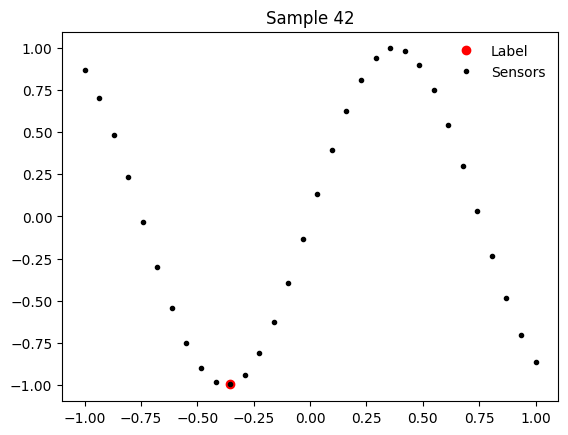

In [4]:
x, u, y, v = dataset[42]
plt.plot(y, v, 'ro', label='Label')
plt.plot(x, u, 'k.', label='Sensors')
plt.legend()
plt.title("Sample 42")
plt.show()

## Operator

In this example, we use a `NaiveIntegralKernel` as neural operator with a
`NeuralNetworkKernel` as kernel function.

In [5]:
kernel = NeuralNetworkKernel(dataset.shapes, kernel_width=128, kernel_depth=8)
operator = NaiveIntegralKernel(kernel)

## Training

Train the neural operator.

In [6]:
Trainer(operator).fit(dataset, tol=1e-3, batch_size=128)

Model parameters: 116097
Device: mps
Epoch 302:  loss/train = 9.9629e-04  (0.016 s/epoch)


## Plotting

Plot model predictions for training data.

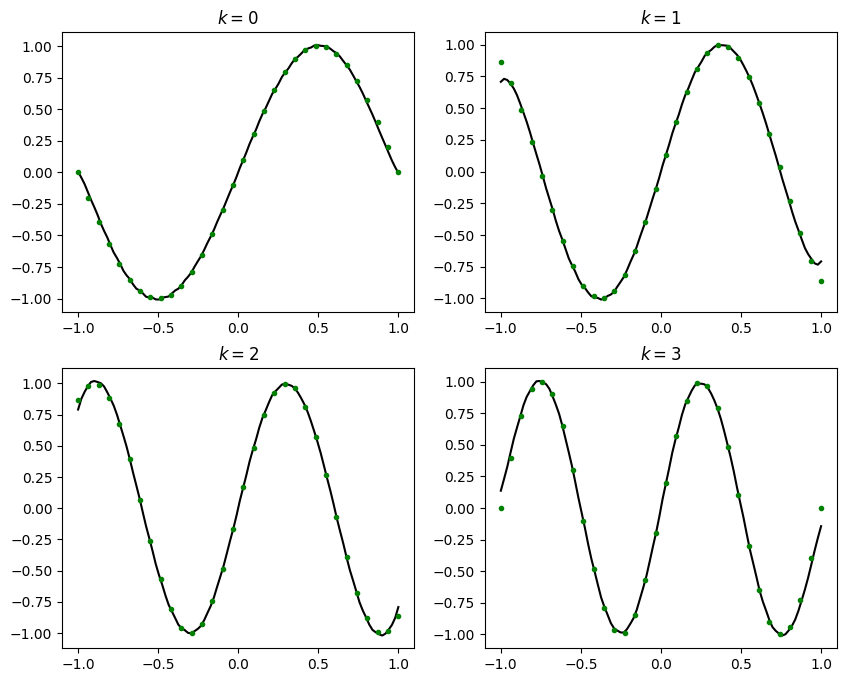

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i in range(len(sine)):
    ax = axs[i//2][i%2]
    x, u = sine.x[i], sine.u[i]
    y = torch.linspace(-1, 1, 100).reshape(-1, 1)
    v = operator(x.unsqueeze(0), u.unsqueeze(0), y.unsqueeze(0)).squeeze(0).detach()
    ax.plot(y, v, 'k-', label='Prediction')
    ax.plot(x, u, 'g.', label='Sensors')
    ax.set_title(f"$k = {i}$")

# Generalization

Plot prediction on a test sample which was not part of the training set.

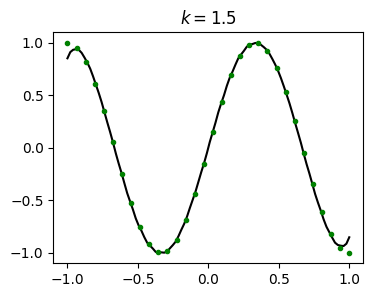

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
i_test = 1.5

x, u = sine.generate_observation(i_test)
y = torch.linspace(-1, 1, 100).reshape(-1, 1)
v = operator(x.unsqueeze(0), u.unsqueeze(0), y.unsqueeze(0)).squeeze(0).detach()
ax.plot(y, v, 'k-', label='Prediction')
ax.plot(x, u, 'g.', label='Sensors')
ax.set_title(f"$k = {i_test}$")
plt.show()